In [37]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

# Visualization packages
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io, filters, constants
from analysis import util
from web_analysis import parse_robots


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
data = io.read_json("robots-data/temporal_robots_data_1.json")

In [77]:
# Reconfiguring years if they are MM-DD-YYYY instead of desired YYYY-MM-DD:
data2 = defaultdict(dict)
for k, vs in data.items():
    for v, vals in vs.items():
        a, b, c = v.split("-")
        data2[k]["-".join([c,a,b])] = vals

data = data2

In [82]:
# Print out start and end years of the data:

all_times = []
for k, vs in data.items():
    for time in vs:
        all_times.append(time)
all_times = set(all_times)
print(min(all_times))
print(max(all_times))
print(sorted(all_times)[:10])
print(sorted(all_times)[-10:])

2016-01-01
2024-04-19
['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10']
['2024-04-09', '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19']


In [112]:
def find_closest_time_key(dates, target_period, direction):
    """Given a list of dates, and a specific target date, find the closest
    date in the list to the target date, in the specified direction."""
    
    # Extract the target start date and end date from the target period
    target_start_date = target_period.start_time.to_pydatetime().date()
    target_end_date = target_period.end_time.to_pydatetime().date()

    closest_key = None
    # Set initial comparison values based on search direction
    if direction == "backward":
        compare = lambda current_date, closest_date: current_date > closest_date
        target_date = target_end_date
    else:  # "forward"
        compare = lambda current_date, closest_date: current_date < closest_date
        target_date = target_start_date

    # Iterate through dictionary keys
    for key in dates:
        # Convert pandas timestamp to datetime.date
        key_date = key.to_pydatetime().date()
        
        if (key_date <= target_date if direction == "backward" else key_date >= target_date):
            if closest_key is None or compare(key_date, closest_key.to_pydatetime().date()):
                closest_key = key
    return closest_key


In [113]:
TRACK_AGENT_LIST = [
    "*All Agents*", "*", "GPTBot", "CCBot", "Google-Extended", "ChatGPT-User", "anthropic-ai", "cohere-ai"
]

# Specify the time range and frequency for aggregation
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2024-04-30')
frequency = 'M'  # "W" = Weekly frequency

# Convert date strings to pandas datetime for easier manipulation
# {URL --> Date --> Agent --> Status}
status_summary = defaultdict(lambda: defaultdict(lambda: defaultdict(str)))
for url, date_to_robots in data.items():
    if None in date_to_robots:
        print(url)
    _, parsed_result = robots_stats, url_interpretations = parse_robots.analyze_robots(date_to_robots)
    for date_str, agent_to_status in parsed_result.items():
        date = pd.to_datetime(date_str)
        for agent in TRACK_AGENT_LIST:
            status = agent_to_status.get(agent, agent_to_status.get("*", "none"))
            status_summary[url][date][agent] = status


# Fill in the missing weeks for each URL
date_range = pd.period_range(start_date, end_date, freq=frequency)
# {Period --> Agent --> Status --> set(URLs)}
filled_status_summary = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
for wi, period in enumerate(date_range):
    if wi % 10 == 0:
        print(period)
    for agent in TRACK_AGENT_LIST:
        for url, date_agent_status in status_summary.items():
            robots_time_keys = sorted(list(date_agent_status.keys()))
            time_key = find_closest_time_key(robots_time_keys, period, direction="backward")
            if time_key is None:
                status = "N/A"
            else:
                status = date_agent_status[time_key][agent]
            filled_status_summary[period][agent][status].add(url)


# Convert results to a DataFrame for easy viewing and manipulation
summary_df_list = []
for period, agent_statuses in filled_status_summary.items():
    for agent, statuses in agent_statuses.items():
        for status, urls in statuses.items():
            summary_df_list.append({'period': period, 'agent': agent, 'status': status, 'count': len(urls)})

summary_df = pd.DataFrame(summary_df_list)


2016-01


/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_74701/766665131.py:4: UserWarning: Discarding nonzero nanoseconds in conversion.
  target_end_date = target_period.end_time.to_pydatetime().date()


2016-11
2017-09
2018-07
2019-05
2020-03
2021-01
2021-11
2022-09
2023-07
       period         agent status  count
0     2016-01  *All Agents*   none    118
1     2016-01  *All Agents*    N/A    381
2     2016-01  *All Agents*   some    327
3     2016-01  *All Agents*    all      3
4     2016-01             *   none    139
...       ...           ...    ...    ...
3187  2024-04  anthropic-ai   some    498
3188  2024-04  anthropic-ai    all     26
3189  2024-04     cohere-ai   none    303
3190  2024-04     cohere-ai   some    509
3191  2024-04     cohere-ai    all     17

[3192 rows x 4 columns]


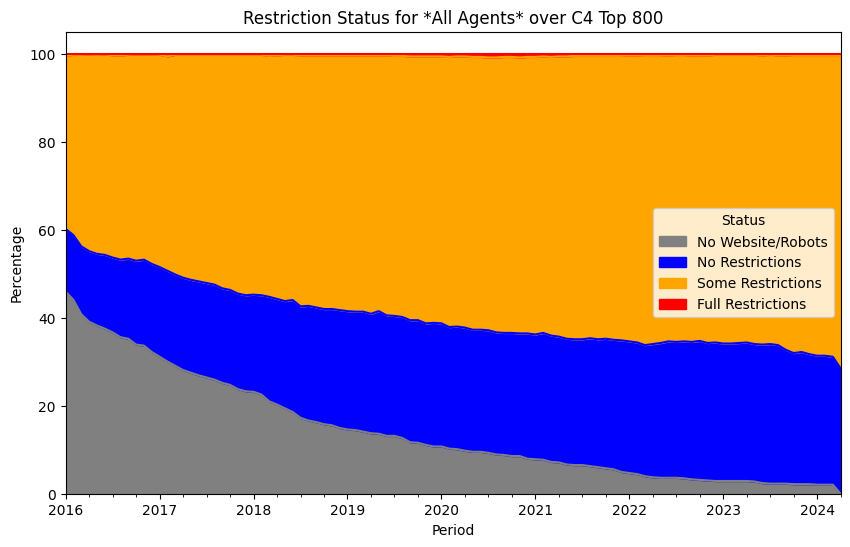

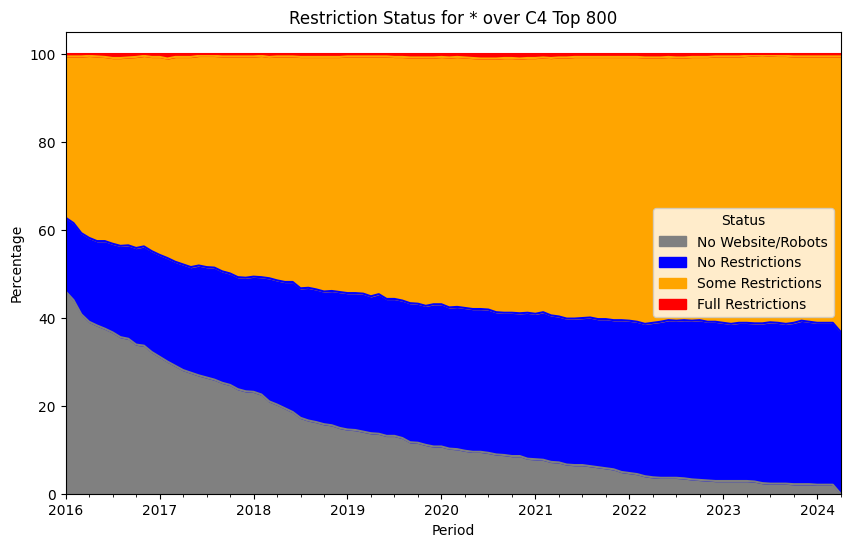

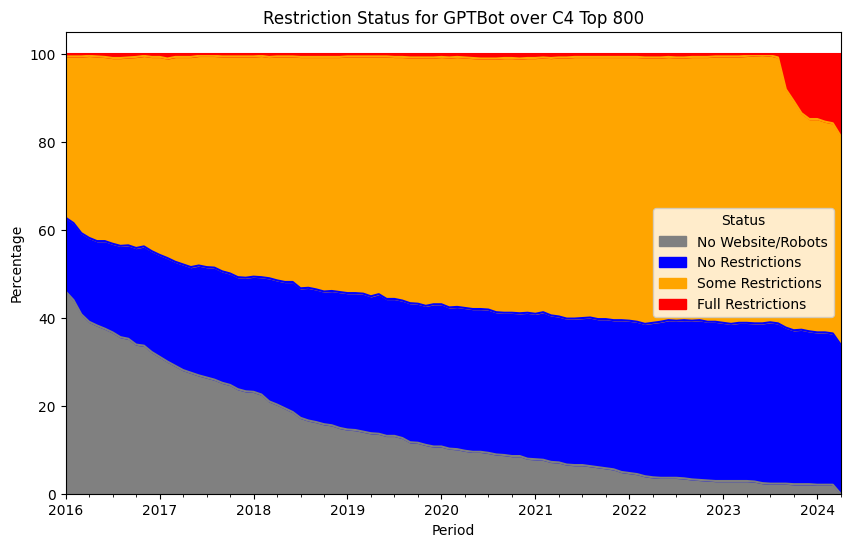

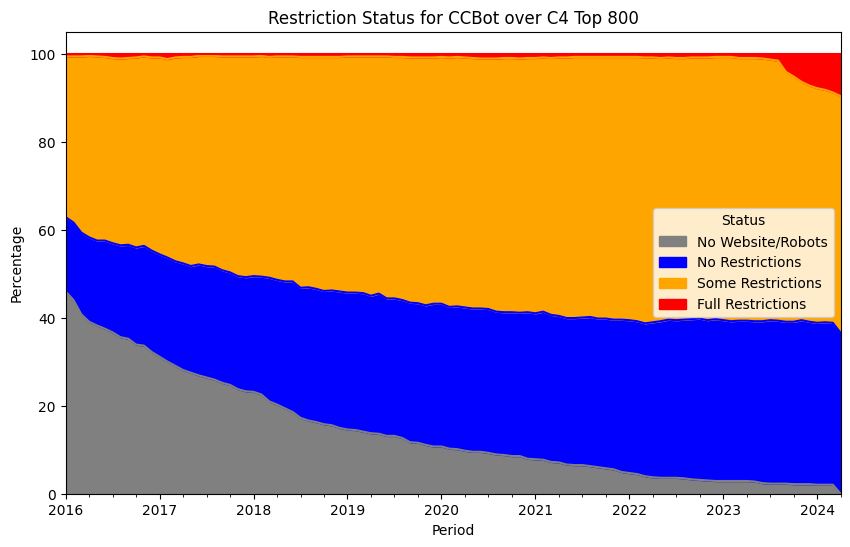

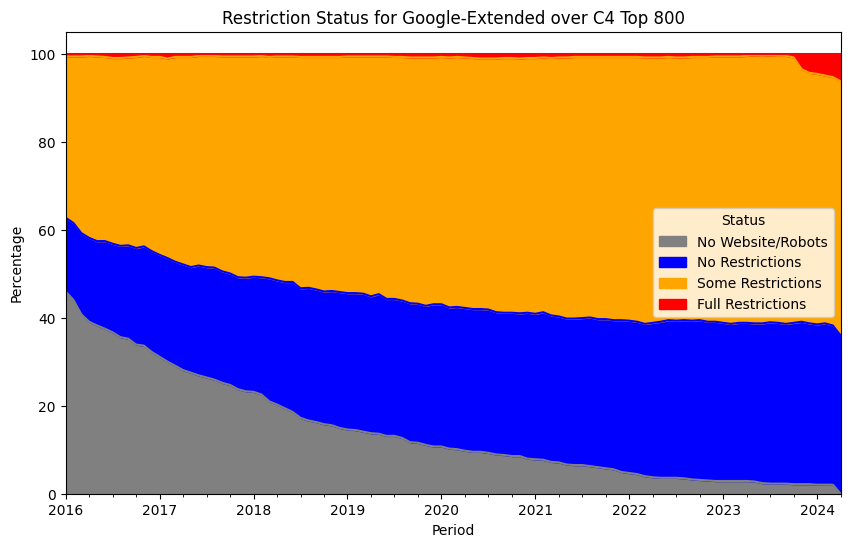

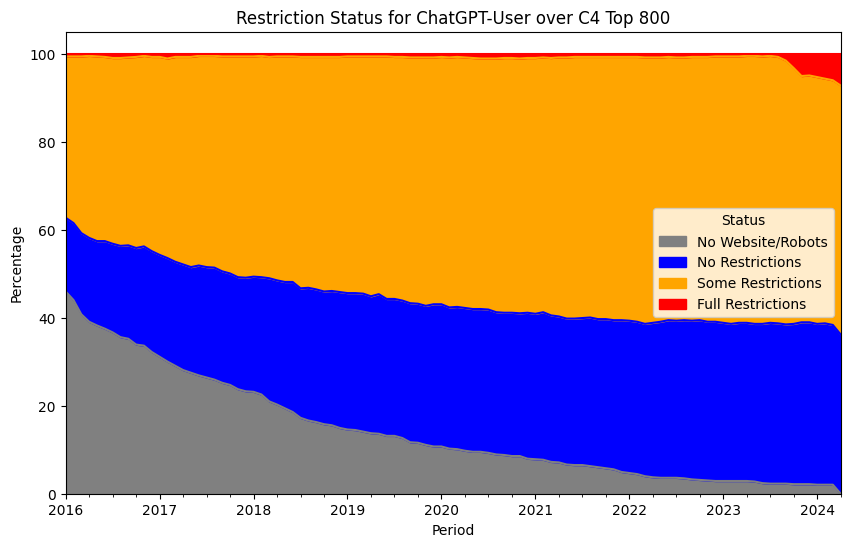

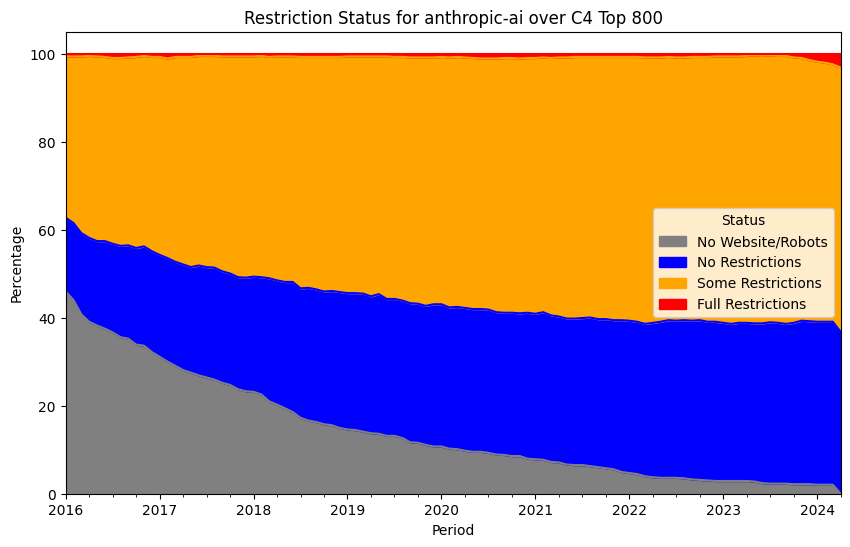

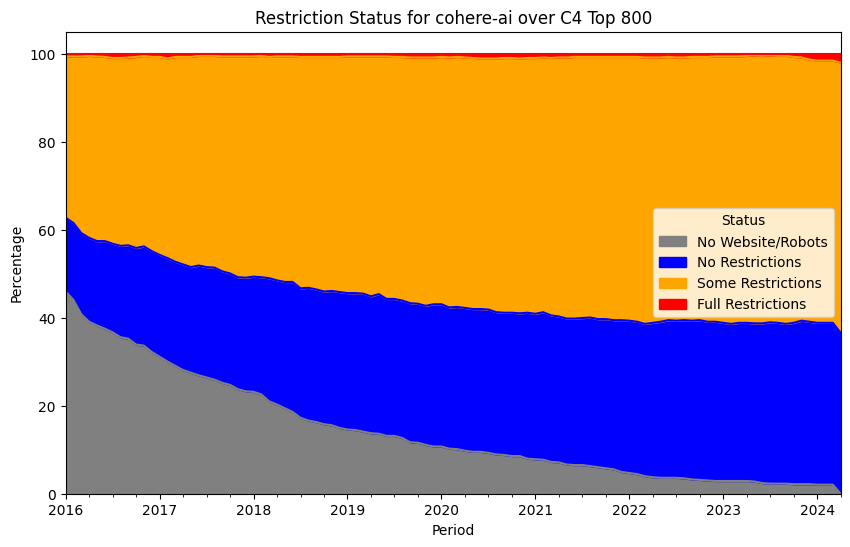

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

for agent_type in TRACK_AGENT_LIST:
# agent_type = '*All Agents*'
# agent_type = 'GPTBot'

    # Filter the DataFrame for the agent labeled '*'
    filtered_df = summary_df[summary_df['agent'] == agent_type]
    
    # Group by 'period' and 'status', and sum up the 'count'
    grouped_df = filtered_df.groupby(['period', 'status'])['count'].sum().unstack(fill_value=0)
    
    # Optional: Reorder the columns as desired (replace 'status1', 'status2', etc., with your actual status names)
    ordered_statuses = ['N/A', 'none', 'some', 'all']  # Example: reorder as per your preference
    grouped_df = grouped_df[ordered_statuses]
    
    # Calculate the total counts for each period
    total_counts = grouped_df.sum(axis=1)
    
    # Calculate the percentage of each status per period
    percent_df = grouped_df.div(total_counts, axis=0) * 100
    
    # Specify colors for each stack (ensure this matches the order of statuses in 'ordered_statuses')
    colors = ['gray', 'blue', 'orange', 'red']  # Assign colors to each status
    
    # Optional: Rename columns for custom labels in the legend
    percent_df.columns = ['No Website/Robots', 'No Restrictions', 'Some Restrictions', 'Full Restrictions']  # Example labels
    # gray (n/a), blue (some), red (none), orange (all)
    # Plotting the stacked area chart
    # percent_df.plot(kind='area', stacked=True, figsize=(10, 6))#, color=colors)
    percent_df.plot(kind='area', stacked=True, figsize=(10, 6), color=colors)
    
    plt.title(f"Restriction Status for {agent_type} over C4 Top 800")
    plt.xlabel('Period')
    plt.ylabel('Percentage')
    plt.legend(title='Status')
    plt.show()


In [ ]:
# 2. "*" over time, compared to a few agents [Google, OpenAI, Meta, Cohere, Anthropic, etc]